In [56]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import animation

__ATTENTION:__ Sometimes there are some errors with cells or class etributes. In this case just
try to restart the python kernel.

In [57]:
from src import ShrodingerEquation, PotentialBarriers

Запишем общий вид уравнения Шрёдингера

$$H \langle \psi \rangle = E \psi$$

где $\psi$ -- волновая функция, $H$ -- оператор полной энергии (гамильтониан), $E$ -- полная энергия 
системы. Вид гамильтониана

$$H = - \frac{\hbar}{2m} \Delta + U(r)$$

где $\Delta$ -- оператор Лапласа.

Это запись для уравнения Шрёдингера, независимого от времени (стационарного состояния). При записи, 
фактически в правой части мы перешли от оператора, дающего зависимость по времени к величине полной 
энергии. Для того, чтобы записать уравнение, зависящее от времени перейдем к операторам в обеих частях.

$$H \langle \psi \rangle = E  \langle \psi \rangle$$

где $E$ теперь является оператором

$$E = i \hbar \frac{\partial}{\partial t}$$

Теперь уравнение имеет следующий вид

$$i \hbar \frac{\partial \psi(r, t)}{\partial t} = H \langle \psi(r, t) \rangle$$

В этом случае решение дифференциального уравнения можно выразить следующим образом

$$\psi(r, t) = \exp(-i H t) \psi(r, 0)$$

Будем рассматривать распространение волнового пакета вдоль оси $Ox$. Тогда гамильтониан запишем следующим 
образом

$$H = - \frac{\hbar}{2m} \frac{\partial^2}{\partial x^2} + U(x)$$

Для вычисления второй производной воспользуемся формулой вычислительной метематики

$$\frac{\partial^2 f}{\partial x^2} _{x = j \Delta x} = \frac{f_{j+1} - 2f_{j} + f_{j-1}}{dx^2}$$

Тогда, если $f$ представляет собой вектор дискретных значений

$$
\begin{pmatrix}
f_1 \\
f_2 \\
\dots \\
f_N
\end{pmatrix}
$$

То вектор значений вторых происзводных этой функции в узлах построенной сетки можно получить с помощью
трехдиагональной матрицы

$$
\begin{pmatrix}
f_1'' \\
f_2'' \\
\dots \\
f_N''
\end{pmatrix}
= \frac{1}{dx^2}
\begin{pmatrix}
-2 &  1 & 0 & 0     & \dots & 0 & 0 \\
1  & -2 & 1 & 0     & \dots & 0 & 0 \\
0  & 1  &-2 & 1     & \dots & 0 & 0 \\
   &    &   & \dots &       &   &   \\
0  & 0  & 0 & 0     & \dots &-2 & 1 \\
\end{pmatrix}
\begin{pmatrix}
f_1 \\
f_2 \\
\dots \\
f_N
\end{pmatrix}
$$

Значение потенциальной энергии $U$ так же можно представить в виде вектора значений в узлах сетки. Тогда
действие оператора $H$ на вектор значений волновой функции $\psi$ можно представить, как умножение вектора 
значений волновой функции на матрицу

$$
H =
- \frac{\hbar}{2 m dx^2}
\begin{pmatrix}
-2 &  1 & 0 & 0     & \dots & 0 & 0 \\
1  & -2 & 1 & 0     & \dots & 0 & 0 \\
0  & 1  &-2 & 1     & \dots & 0 & 0 \\
   &    &   & \dots &       &   &   \\
0  & 0  & 0 &       & \dots &-2 & 1 \\\end{pmatrix}
\begin{pmatrix}
V_1 &  0  & 0   & 0     & \dots & 0 & 0 \\
0   & V_2 & 0   & 0     & \dots & 0 & 0 \\
0   & 0   & V_3 & 0     & \dots & 0 & 0 \\
    &     &     & \dots &       &   &   \\
0   & 0   & 0   & 0     & \dots & 0 & V_N \\\end{pmatrix}
$$

In [58]:
from scipy import integrate

In [59]:
# зададим количество точек на пространственной сетке
N = 1000
# зададим сетку пространственного диапазона
x_start = -120
x_end = 120

x_dense, dx = np.linspace(x_start, x_end, N, retstep=True)

# зададим параметры волнового пакета
# начальное положение
x0 = 0
# ширина
sigma0 = 5.0
# начальная энергия и импульс (считаем что m = 1)
E0 = 0.5
p0 = math.sqrt(2*E0)

# зададим начальный вид волновой функции, как гаусовский полновой пакет
psi0 = ShrodingerEquation.GaussWavePackage(x_dense, x0, sigma0, p0)

# зададим потенциальный барьер
V_dense = np.zeros(N)

# волновая функция (заданная как объект)
psi = ShrodingerEquation.WaveFunction(psi0, x_dense, V_dense)

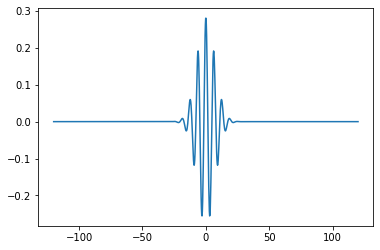

In [60]:
plt.plot(x_dense, psi.psi.real)

In [61]:
# комплексное сопряжение
print(psi.psi[0])
print(psi.psi.conjugate()[0])

(6.657107717825699e-64-4.7473366922048666e-64j)
(6.657107717825699e-64+4.7473366922048666e-64j)


$$\langle f \rangle = \int \psi^* f \psi $$

в данном случае в правой части $f$ -- есть оператор. Таким образом

$$\langle x \rangle = \int \psi^* x \psi $$

In [62]:
x = np.linspace(1, 5, 100)
y = np.exp(x)

I= integrate.simps(y, x)
print(I)

145.69528675176485


In [63]:
y = psi.psi.conjugate() * x_dense * psi.psi
y = y.real

X = integrate.simps(y, x_dense)
print(X)

0.0


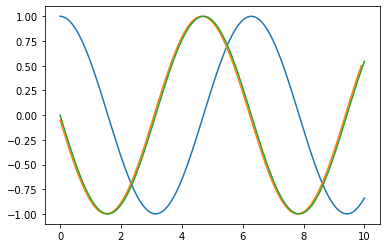

In [64]:
'''
Указание к использованию np.diff
Забавная это все таки функция (я бы лучше написал)
Во-первых, она режет исходный массив. Если вы даете ей на вход массив длины N, то на
выход она возвращает массив N-1
Во-вторых, она не делит на шаг сетки, а по-сути просто возвращает разницу между соседними значениями
(подробнее смотри документацию)
'''

x, d_x = np.linspace(0, 10, 100, retstep=True)
y = np.cos(x)
plt.plot(x, y)
y1 = np.diff(y, 1) / d_x
plt.plot(x[:-1], y1)
plt.plot(x, -np.sin(x))

In [66]:
operator_p2psi = -1j * (np.diff(psi.psi, 1) / dx)
y = psi.psi.conjugate()[:-1] * operator_p2psi
y = np.sqrt(y.real**2 + y.imag**2)
X = integrate.simps(y, x_dense[:-1])
print(X)

1.0023565620323294


In [68]:
psi.PsiTimeEvolute()
operator_p2psi = -1j * (np.diff(psi.psi, 1) / dx)
y = psi.psi.conjugate()[:-1] * operator_p2psi
y = np.sqrt(y.real**2 + y.imag**2)
X = integrate.simps(y, x_dense[:-1])
print(X)
psi.PsiTimeEvolute()
operator_p2psi = -1j * (np.diff(psi.psi, 1) / dx)
y = psi.psi.conjugate()[:-1] * operator_p2psi
y = np.sqrt(y.real**2 + y.imag**2)
X = integrate.simps(y, x_dense[:-1])
print(X)
psi.PsiTimeEvolute()
operator_p2psi = -1j * (np.diff(psi.psi, 1) / dx)
y = psi.psi.conjugate()[:-1] * operator_p2psi
y = np.sqrt(y.real**2 + y.imag**2)
X = integrate.simps(y, x_dense[:-1])
print(X)
psi.PsiTimeEvolute()
operator_p2psi = -1j * (np.diff(psi.psi, 1) / dx)
y = psi.psi.conjugate()[:-1] * operator_p2psi
y = np.sqrt(y.real**2 + y.imag**2)
X = integrate.simps(y, x_dense[:-1])
print(X)
psi.PsiTimeEvolute()
operator_p2psi = -1j * (np.diff(psi.psi, 1) / dx)
y = psi.psi.conjugate()[:-1] * operator_p2psi
y = np.sqrt(y.real**2 + y.imag**2)
X = integrate.simps(y, x_dense[:-1])
print(X)
psi.PsiTimeEvolute()
operator_p2psi = -1j * (np.diff(psi.psi, 1) / dx)
y = psi.psi.conjugate()[:-1] * operator_p2psi
y = np.sqrt(y.real**2 + y.imag**2)
X = integrate.simps(y, x_dense[:-1])
print(X)
psi.PsiTimeEvolute()
operator_p2psi = -1j * (np.diff(psi.psi, 1) / dx)
y = psi.psi.conjugate()[:-1] * operator_p2psi
y = np.sqrt(y.real**2 + y.imag**2)
X = integrate.simps(y, x_dense[:-1])
print(X)

1.0023878327113096
1.0023981212405217
1.0024048239839194
1.0024079444583336
1.0024075015231328
1.0024035290105915
1.0023960752050778
